In [2]:
# Import
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
from torchvision import models, transforms
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture
import umap
import matplotlib.pyplot as plt
import sys

module_path = os.path.abspath(os.path.join('..', '..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Preprocessing
from joblib import Parallel, delayed
import utils
from utils import grayscale_directory, clahe_directory, apply_denoise_tv_chambolle_directory, circle_crop_directory, create_comparison_file, analyseClustering

# Distance computing
from kornia_matcher import extract_kornia_matches_in_directory
import pandas as pd

# Clustering
from sklearn.cluster import AgglomerativeClustering
import hdbscan

In [ ]:
# Variables
import variables


## Preprocessing obverse
exp1_obverse = os.path.join(variables.results_directory_obverse, "01_grayscale") # variables.results_directory+"01_grayscale\\"
exp2_obverse = os.path.join(variables.results_directory_obverse, "02_histogram_equalization")
exp3_obverse = os.path.join(variables.results_directory_obverse, "03_denoise")
exp4_obverse = os.path.join(variables.results_directory_obverse, "04_histogram_equalization")
exp5_obverse = os.path.join(variables.results_directory_obverse, "05_circle_crop")
folders_obverse = [exp1_obverse, exp2_obverse, exp3_obverse, exp4_obverse, exp5_obverse]

preprocessed_images_path_obverse = exp5_obverse
images_folder_path_obverse = variables.images_directory_obverse

## Distance computing obverse
matching_file_path_obverse = variables.results_directory_obverse + variables.matching_file_name_obverse
clustering_file_path_obverse = variables.results_directory_obverse + variables.clustering_file_name_obverse
#graph_file_path = variables.results_directory + variables.graph_file_name

## Preprocessing reverse
exp1_reverse = os.path.join(variables.results_directory_reverse, "01_grayscale") # variables.results_directory+"01_grayscale\\"
exp2_reverse = os.path.join(variables.results_directory_reverse, "02_histogram_equalization")
exp3_reverse = os.path.join(variables.results_directory_reverse, "03_denoise")
exp4_reverse = os.path.join(variables.results_directory_reverse, "04_histogram_equalization")
exp5_reverse = os.path.join(variables.results_directory_reverse, "05_circle_crop")
folders_reverse = [exp1_reverse, exp2_reverse, exp3_reverse, exp4_reverse, exp5_reverse]

preprocessed_images_path_reverse = exp5_reverse
images_folder_path_reverse = variables.images_directory_reverse

## Distance computing obverse
matching_file_path_reverse = variables.results_directory_reverse + variables.matching_file_name_reverse
clustering_file_path_reverse = variables.results_directory_reverse + variables.clustering_file_name_reverse
#graph_file_path = variables.results_directory + variables.graph_file_name
## Clustering
# linkage option: "complete", "average"
clusterer = AgglomerativeClustering(n_clusters=variables.number_of_clusters, linkage='complete', metric='precomputed')  
#clusterer = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=2)

In [ ]:

IMAGE_FOLDER = "C:\\Users\\edvin\\Desktop\\DataChallenge\\DataChallenge2025_bueschelquinare\\reverse_results\\05_circle_crop"  # <-- UPDATE
OUTPUT_FEATURES = "resnet50_features.npy"
OUTPUT_LABELS = "bgmm_labels.npy"
CSV_OUT = "coin_cluster_results.csv"

model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove final FC layer
model.eval()

c:\Users\edvin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\edvin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
def extract_feature(image_path):
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0)
    with torch.no_grad():
        emb = model(img_tensor).squeeze().numpy()
    return emb


features = []
filenames = []
for fname in tqdm(sorted(os.listdir(IMAGE_FOLDER))):
    if fname.lower().endswith((".jpg", ".png", ".jpeg")):
        try:
            fpath = os.path.join(IMAGE_FOLDER, fname)
            features.append(extract_feature(fpath))
            filenames.append(fname)
        except Exception as e:
            print(f"Skipping {fname}: {e}")
            
features = np.array(features)
np.save(OUTPUT_FEATURES, features)


pca = PCA(n_components=50)

features_pca = pca.fit_transform(features)

100%|██████████| 566/566 [00:33<00:00, 16.89it/s]


In [ ]:
bgmm = BayesianGaussianMixture(
    n_components=30,
    weight_concentration_prior_type='dirichlet_process',
    weight_concentration_prior=0.005,
    covariance_type='full',
    max_iter=1000,
    random_state=42
)

labels = bgmm.fit_predict(features_pca)
np.save(OUTPUT_LABELS, labels)

c:\Users\edvin\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


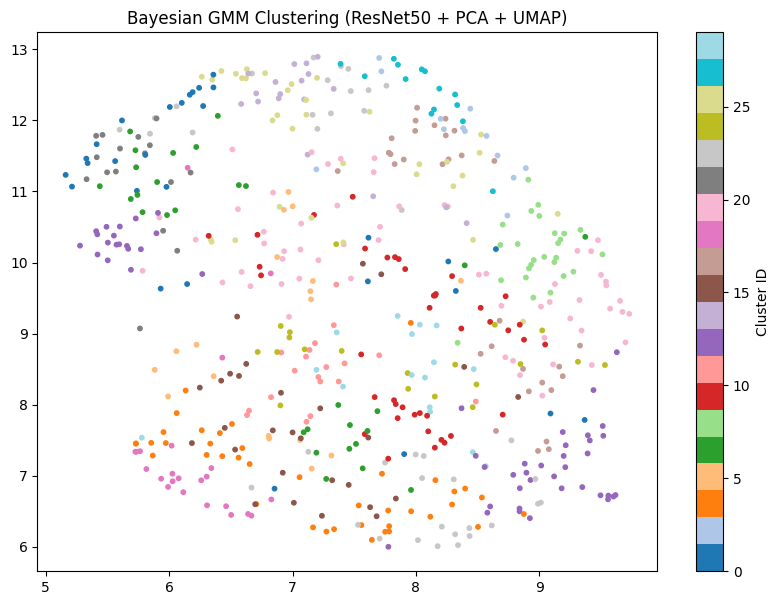

In [ ]:

embedding = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42).fit_transform(features_pca)

plt.figure(figsize=(10, 7))
plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='tab20', s=10)
plt.title("Bayesian GMM Clustering (ResNet50 + PCA + UMAP)")
plt.colorbar(label="Cluster ID")
plt.show()

In [ ]:
import numpy as np
import pandas as pd


features = np.load("resnet50_features.npy")       
labels = np.load("bgmm_labels.npy")               
filenames = filenames        


df = pd.DataFrame({
    "filename": filenames,
    "cluster": labels
})


df.to_csv("coin_cluster_results.csv", index=False)
print("Saved to coin_cluster_results.csv")


Saved to coin_cluster_results.csv
